<a href="https://colab.research.google.com/github/jackzensen/SMS-Text-Classification/blob/main/Copy_of_SMS_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [ ]:
# import libraries
# try:
#   # %tensorflow_version only exists in Colab.
#   !pip install tf-nightly
# except Exception:
#   pass
# !pip install tensorflow
# !pip install numpy --upgrade --ignore-installed
!pip install -q tensorflow-text

import requests
import tensorflow_text as tf_text
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# !pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

     |████████████████████████████████| 4.9 MB 8.0 MB/s 
2.7.0


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

train_file_path = "https://cdn.freecodecamp.org/project-data/sms/train-data.tsv"
test_file_path = "https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv"

--2022-01-20 03:13:01--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.02s   

2022-01-20 03:13:02 (15.0 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2022-01-20 03:13:02--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [ ]:
# train_files = pd.read_csv('https://cdn.freecodecamp.org/project-data/sms/train-data.tsv', header=0, names=['label', 'message'], sep='\t')
train_files = pd.read_csv('train-data.tsv', sep='\t', header=None, names=['Classification', 'Message'])
valid_files = pd.read_csv('valid-data.tsv', sep='\t', header=None, names=['Classification', 'Message'])

In [ ]:
# Configure parameters
batch_size = 32
epochs = 15
BUFFER_SIZE = 10000


In [ ]:
!mkdir trainData
!mv train-data.tsv trainData
!mkdir valData
!mv valid-data.tsv valData

In [ ]:
# this shows there are duplicates that probably need to be removed from the datasets
train_files.describe()
duplicatedRow = train_files[train_files.duplicated()]
print(duplicatedRow[:10])

    Classification                                            Message
298           spam  want to funk up ur fone with a weekly new tone...
385            ham  ok then i will come to ur home after half an hour
489            ham  watching cartoon, listening music &amp; at eve...
494            ham                             sorry, i'll call later
525            ham                             sorry, i'll call later
530            ham  i am in escape theatre now. . going to watch k...
555            ham                             sorry, i'll call later
593            ham                                              ok...
621            ham                                                ok.
631            ham                             sorry, i'll call later


In [ ]:
# Remove duplicate entries
train_files = train_files.drop_duplicates()
valid_files = valid_files.drop_duplicates()
train_files.describe()

,Classification,Message
count,3935,3935
unique,2,3935
top,ham,"8 at the latest, g's still there if you can sc..."
freq,3430,1


In [ ]:
train_files['Classification'].value_counts()
valid_files['Classification'].value_counts()

# ham messages are much more frequent than spam, so we should balance the data before training the model with it
lenTrainSpam = len(train_files[train_files['Classification'] == 'spam'])

# gather lenTrainSpam amount of random samples where message is considered ham
trainHam = train_files[train_files['Classification'] == 'ham'].sample(n=lenTrainSpam)
trainSpam = train_files[train_files['Classification'] == 'spam'].sample(n=lenTrainSpam)

# Merge lenTrainSpam amount of ham and spam samples into one dataframe
trainSet = trainHam.merge(trainSpam,how='outer', on=None)

# Shuffle dataset
trainSet = trainSet.sample(len(trainSet), random_state=1)
trainSet

,Classification,Message
915,spam,someone u know has asked our dating service 2 ...
701,spam,urgent! your mobile number has been awarded wi...
293,ham,"not for possession, especially not first offense"
507,spam,i'd like to tell you my deepest darkest fantas...
970,spam,urgent! call 09066612661 from landline. your c...
...,...,...
767,spam,please call 08712402902 immediately as there i...
72,ham,i love to wine and dine my lady!
908,spam,pdate_now - double mins and 1000 txts on orang...
235,ham,ü takin linear algebra today?


# New Section

In [ ]:
# Encode hams as 0, spams as 1 to allow for a binary model
trainSet['Classification'] = trainSet['Classification'].map({'ham':0, 'spam':1})
valid_files['Classification'] = valid_files['Classification'].map({'ham':0, 'spam':1})

trainSet.head()

,Classification,Message
915,1,someone u know has asked our dating service 2 ...
701,1,urgent! your mobile number has been awarded wi...
293,0,"not for possession, especially not first offense"
507,1,i'd like to tell you my deepest darkest fantas...
970,1,urgent! call 09066612661 from landline. your c...


In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token=oov_tok)
tokenizer.fit_on_texts(trainSet['Message'])
X_train = tokenizer.texts_to_sequences(trainSet['Message'])
X_test = tokenizer.texts_to_sequences(valid_files['Message'])

X_train_padded = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Y_test = valid_files['Classification']
Y_train = trainSet['Classification']

Y_train_array = np.array(Y_train)
Y_test_array = np.array(Y_test)

word_index = tokenizer.word_index

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
  
    tf.keras.layers.Dense(8, activation='relu'),  tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 16,145
Trainable params: 16,145
Non-trainable params: 0
____________________________________________________

In [ ]:
num_epochs = 55
history = model.fit(X_train_padded, Y_train_array, epochs=num_epochs, validation_data=(X_test_padded, Y_test_array))

Epoch 1/55
32/32 [==============================] - 2s 44ms/step - loss: 0.6922 - accuracy: 0.4990 - val_loss: 0.6735 - val_accuracy: 0.8695
Epoch 2/55
32/32 [==============================] - 0s 5ms/step - loss: 0.6884 - accuracy: 0.5307 - val_loss: 0.6686 - val_accuracy: 0.8695
Epoch 3/55
32/32 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.4861 - val_loss: 0.6599 - val_accuracy: 0.8658
Epoch 4/55
32/32 [==============================] - 0s 4ms/step - loss: 0.6775 - accuracy: 0.5584 - val_loss: 0.6481 - val_accuracy: 0.8844
Epoch 5/55
32/32 [==============================] - 1s 45ms/step - loss: 0.6665 - accuracy: 0.6495 - val_loss: 0.6355 - val_accuracy: 0.9474
Epoch 6/55
32/32 [==============================] - 0s 5ms/step - loss: 0.6409 - accuracy: 0.8446 - val_loss: 0.5996 - val_accuracy: 0.9526
Epoch 7/55
32/32 [==============================] - 0s 4ms/step - loss: 0.6010 - accuracy: 0.8693 - val_loss: 0.5903 - val_accuracy: 0.9199
Epoch 8/55
32/32 [

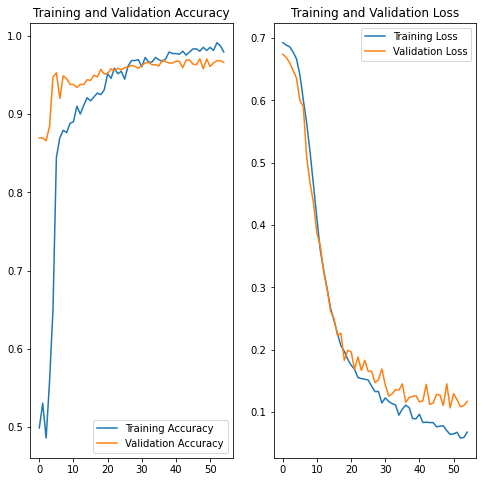

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  predictions = []
  pred_text = pd.Series(pred_text)
  tokenized_string = tokenizer.texts_to_sequences(pred_text)
  pad_text_sequence = pad_sequences(tokenized_string, maxlen=max_length)
  result = model.predict(pad_text_sequence)[0]
  
  if result[0] <= 0.5:
    predictions = [result[0], "ham"]
  else:
    predictions = [result[0], "spam"]
  print(predictions)
  return predictions


pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)


[0.01832077, 'ham']
[0.01832077, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


[0.01832077, 'ham']
[0.58677477, 'spam']
[0.018805355, 'ham']
[0.9959966, 'spam']
[0.99592066, 'spam']
[0.010900795, 'ham']
[0.017705321, 'ham']
You passed the challenge. Great job!
